In [1]:

import numpy as np
import cv2
import os
from configparser import ConfigParser

path_config_file = os.getcwd().split('docrv2_sroie')[0] + 'docrv2_sroie/' + 'config.ini'
common_variable = ConfigParser()
common_variable.read(path_config_file)

import sys

sys.path.append(common_variable['database']['module_path'])

from db_util import *
from db import *

from base.base_data_loader import BaseDataLoader
from utils import dirs
from utils import image_utils
from utils.image_utils import drawBoxes

DB_MAIN_PATH = common_variable['database']['DB_MAIN_PATH']


In [23]:
len(imgs)

4

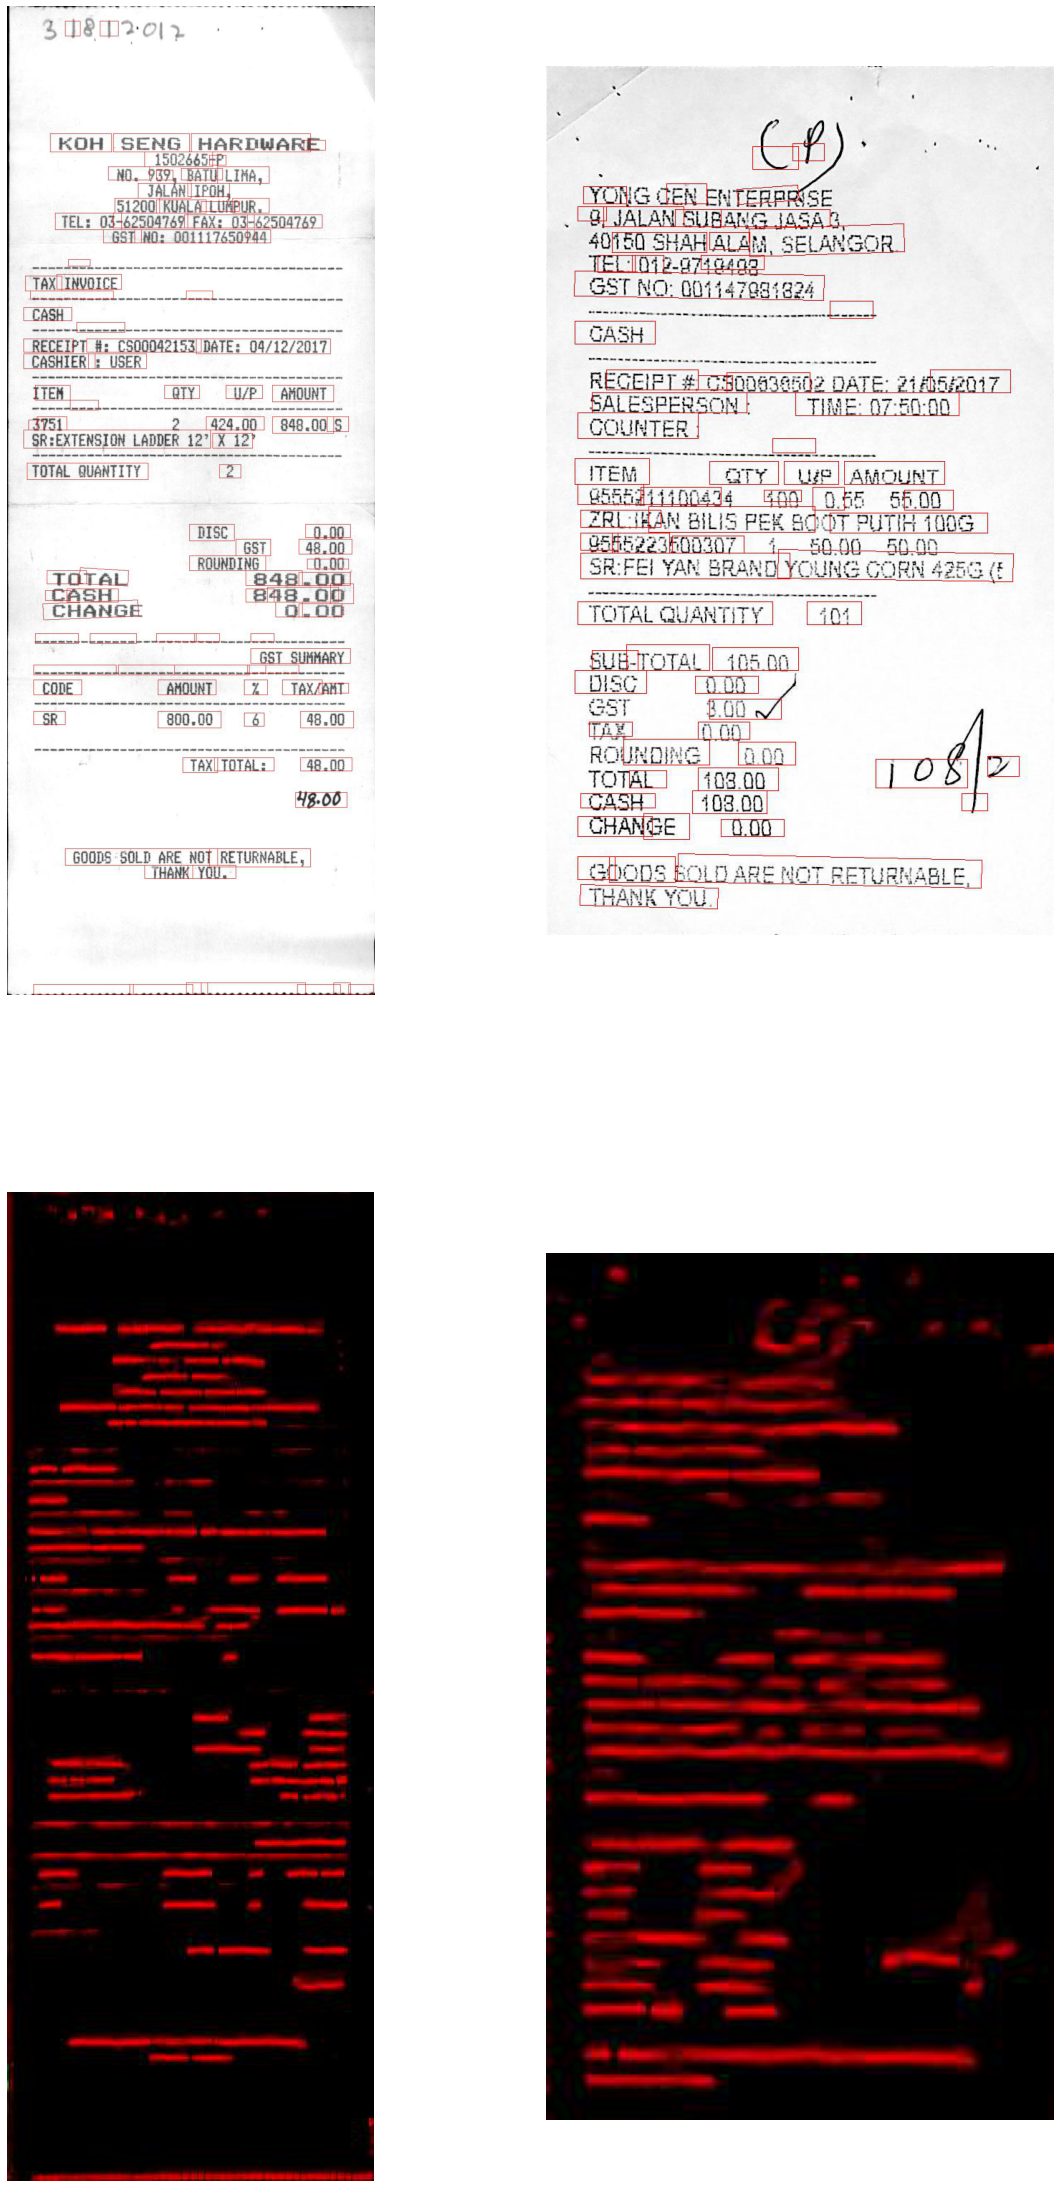

In [28]:
env = open_env('/home/dk/docrv2_sroie/temp/raw_test_task12_2img_preview_detection')
imgs = read_bulk_data_from_db(env,'img')
import matplotlib.pyplot as plt
plt.subplots(2,2,figsize=(20,40))
for idx in range(1,5):
    plt.subplot(2,2,idx)
    plt.imshow(imgs[idx-1])
    plt.axis('off')

In [15]:
denv = open_env('/home/dk/docrv2_sroie/DB/d2gan_styled_combined_from_denoise_100')
dkey = 'img-%09d'%0
lkey = 'char_c-%09d'%0
db = denv.open_db(b'db_data')
with denv.begin(write=False) as txn:
    db_cs = txn.cursor(db)
    img = decode_img(db_cs.get(str(dkey).encode()))
    img = np.array(img)
    tlines = decode_pd(db_cs.get(str(lkey).encode()),
                       sep=get_value_by_key(denv, 'sep'))

# process line
lines = [None] * len(tlines)
for i in range(len(tlines)):
    for j in range(8):
        tlines[i][j] = int(tlines[i][j])
    lines[i] = tuple(tlines[i])
tline = lines

In [54]:
tline

[(50, 26, 50, 26, 50, 41, 50, 41, ' '),
 (52, 26, 68, 26, 68, 41, 52, 41, 'S'),
 (68, 26, 85, 26, 85, 41, 68, 41, 'U'),
 (85, 26, 103, 26, 103, 41, 85, 41, 'N'),
 (103, 26, 112, 26, 112, 41, 103, 41, '-'),
 (112, 26, 127, 26, 127, 41, 112, 41, 'T'),
 (126, 26, 143, 26, 143, 41, 126, 41, 'H'),
 (143, 26, 160, 26, 160, 41, 143, 41, 'U'),
 (160, 26, 165, 26, 165, 41, 160, 41, ':'),
 (165, 26, 172, 26, 172, 41, 165, 41, '1'),
 (172, 26, 187, 26, 187, 41, 172, 41, '0'),
 (187, 26, 202, 26, 202, 41, 187, 41, '0'),
 (202, 26, 217, 26, 217, 41, 202, 41, '0'),
 (223, 26, 240, 26, 240, 41, 223, 41, 'H'),
 (240, 26, 258, 26, 258, 41, 240, 41, 'R'),
 (258, 26, 274, 26, 274, 41, 258, 41, 'S'),
 (280, 26, 289, 26, 289, 41, 280, 41, '-'),
 (295, 26, 309, 26, 309, 41, 295, 41, '2'),
 (309, 26, 323, 26, 323, 41, 309, 41, '2'),
 (323, 26, 337, 26, 337, 41, 323, 41, '3'),
 (337, 26, 352, 26, 352, 41, 337, 41, '0'),
 (358, 26, 375, 26, 375, 41, 358, 41, 'H'),
 (375, 26, 393, 26, 393, 41, 375, 41, 'R'),
 (

In [9]:
size = 512
sratio = [1,3,1,1]
amp = [1,1]
heatmap = image_utils.get_asymmetric_gaussian_heatmap(size, distanceRatio[0], sx=sratio[0], sy=sratio[1],
                                                              amp=amp[0])
heatmap_affinity = image_utils.get_asymmetric_gaussian_heatmap(size, distanceRatio[1], sx=sratio[2],
                                                               sy=sratio[3], amp=amp[1])


In [68]:
#heatmap, 
image_height = 128
image_width = 256
lines = [tline]
#heatmap_affinity=None, 
descale=2
make_channel=True

if heatmap_affinity is None:
    heatmap_affinity = heatmap

textmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')
linkmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')

src = np.array([[0, 0], [heatmap.shape[1], 0], [heatmap.shape[1], heatmap.shape[0]], [0, heatmap.shape[0]]]).astype(
    'float32')

for line in lines:
    previous_link_points = None

    for lind in range(len(line)):
        lvals = line[lind]
        paddx = 3
        paddy = 1
        x1 = lvals[0] - paddx
        y1 = lvals[1] - paddy

        x2 = lvals[2] + paddx
        y2 = lvals[3] - paddy

        x3 = lvals[4] + paddx
        y3 = lvals[5] + paddy

        x4 = lvals[6] - paddx
        y4 = lvals[7] + paddy
        c = lvals[8]

        if c == ' ':
            previous_link_points = None
            continue

        yc = (y4 + y1 + y3 + y2) / (2 * descale)
        xc = (x1 + x2 + x3 + x4) / (2 * descale)

        current_link_points = np.array([[(xc + (x1 + x2) / descale) / 2,
                                         (yc + (y1 + y2) / descale) / 2],
                                        [(xc + (x3 + x4) / descale) / 2,
                                         (yc + (y3 + y4) / descale) / 2]]) / 2
        character_points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]).astype('float32') / descale

        # pylint: disable=unsubscriptable-object
        if previous_link_points is not None:
            link_points = np.array([
                previous_link_points[0], current_link_points[0], current_link_points[1],
                previous_link_points[1]
            ])
            ML = cv2.getPerspectiveTransform(
                src=src,
                dst=link_points.astype('float32'),
            )
            linkmap += cv2.warpPerspective(heatmap_affinity,
                                           ML,
                                           dsize=(linkmap.shape[1],
                                                  linkmap.shape[0])).astype('float32')
        MA = cv2.getPerspectiveTransform(
            src=src,
            dst=character_points,
        )
        textmap += cv2.warpPerspective(heatmap, MA, dsize=(textmap.shape[1], textmap.shape[0])).astype('float32')

        # pylint: enable=unsubscriptable-object
        previous_link_points = current_link_points

if make_channel == False:
    result = np.concatenate([textmap[..., np.newaxis], linkmap[..., np.newaxis]], axis=2).clip(0, 255)
else:
    emptymap = np.zeros(textmap.shape)
    result = np.concatenate([textmap[..., np.newaxis], linkmap[..., np.newaxis], emptymap[..., np.newaxis]],
                          axis=2).clip(0, 255)
#return result
oimg = np.array(result,dtype=np.uint8)

In [106]:
bb = read_bulk_data_from_db(open_env('/home/dk/docrv2_sroie/temp/raw_test_task12_2img_preview_detection'),'img')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1, 3508, 2480, 3)


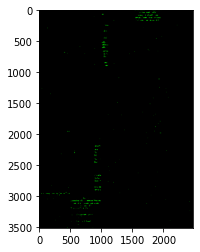

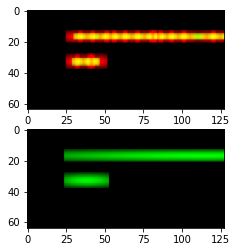

In [69]:
#heatmap, 
image_height = 128
image_width = 256
lines = [tline]
#heatmap_affinity=None, 
descale=2
make_channel=True

if heatmap_affinity is None:
    heatmap_affinity = heatmap

textmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')
linkmap = np.zeros((image_height // descale, image_width // descale)).astype('float32')

src = np.array([[0, 0], [heatmap.shape[1], 0], [heatmap.shape[1], heatmap.shape[0]], [0, heatmap.shape[0]]]).astype(
    'float32')

for line in lines:
    previous_link_points = False

    for lind in range(len(line)):
        lvals = line[lind]
        paddx = 3
        paddy = 1
        x1 = lvals[0] - paddx
        y1 = lvals[1] - paddy

        x2 = lvals[2] + paddx
        y2 = lvals[3] - paddy

        x3 = lvals[4] + paddx
        y3 = lvals[5] + paddy

        x4 = lvals[6] - paddx
        y4 = lvals[7] + paddy
        c = lvals[8]
        
        if previous_link_points is False:
            rx1 = x1
            rx2 = x2
            rx3 = x3
            rx4 = x4
            ry1 = y1
            ry2 = y2
            ry3 = y3
            ry4 = y4
        
        rx1 = np.min([x1, rx1])
        ry1 = np.min([y1, ry1])
        
        rx2 = np.max([x2, rx2])
        ry2 = np.min([y2, ry2])
        
        rx3 = np.max([x3, rx3])
        ry3 = np.max([y3, ry3])
        
        rx4 = np.min([x4, rx4])
        ry4 = np.max([y4, ry4])

        if c == ' ' and previous_link_points == True:
            previous_link_points = False
            character_points = np.array([[rx1, ry1], [rx2, ry2], [rx3, ry3], [rx4, ry4]]).astype('float32') / descale

            MA = cv2.getPerspectiveTransform(
                src=src,
                dst=character_points,
            )

            textmap += cv2.warpPerspective(heatmap, MA, dsize=(textmap.shape[1], textmap.shape[0])).astype('float32')

            continue
        previous_link_points = True

emptymap = np.zeros(textmap.shape)
result = np.concatenate([emptymap[..., np.newaxis], textmap[..., np.newaxis], emptymap[..., np.newaxis]],
                      axis=2).clip(0, 255)
#return result
plt.subplot(2,1,1)
plt.imshow(oimg)
plt.subplot(2,1,2)
plt.imshow(np.array(result,dtype=np.uint8))